In [95]:
import seaborn as sns
import sagemaker
from sagemaker import get_execution_role
import pandas as pd
import boto3
from sklearn.metrics import confusion_matrix

In [2]:
sess = sagemaker.Session()
execution_role = get_execution_role()
print(execution_role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = 'ddonahue'

prefix = 'ddonahue/anomaly' #Replace with the prefix under which you want to store the data if needed

s3 = boto3.resource('s3')

s3.Bucket('anomaly-credit-cards').download_file('paysim1.zip', 'paysim1.zip')

arn:aws:iam::023375022819:role/service-role/AmazonSageMaker-ExecutionRole-20181029T121824


In [13]:
df = pd.read_csv('paysim1.zip', compression='zip')

In [4]:
list(df)

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [32]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,deltaDiff
2006839,179,CASH_OUT,226760.11,C733488987,0.00,0.00,C135736822,479053.83,705813.94,0,0,-226760.0
3112860,235,CASH_OUT,221570.54,C590201724,53934.00,0.00,C116714197,361421.44,582991.98,0,0,-167637.0
2113273,183,CASH_IN,280033.54,C605823595,5606982.95,5887016.49,C476577938,11544791.21,11264757.67,0,0,0.0
4302891,307,PAYMENT,14359.47,C1201124281,0.00,0.00,M1119715384,0.00,0.00,0,0,0.0
97625,10,CASH_IN,371780.23,C1494597714,4720146.60,5091926.83,C310381137,1215487.60,550706.95,0,0,293000.0


In [15]:
df = df.sample(frac=1)

In [31]:
from math import floor
count = len(df.index)
print(count)
splitIndex1 = floor(count * .6)
splitIndex2 = floor(splitIndex1 + floor(count *.2))
print(splitIndex1)
print(splitIndex2)


training_df = df[:splitIndex1]
test_df = df[splitIndex1 + 1:splitIndex2].copy()
validation_df = df[splitIndex2:]

6362620
3817572
5090096


## Feature Engineering

In [33]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,deltaDiff
2006839,179,CASH_OUT,226760.11,C733488987,0.00,0.00,C135736822,479053.83,705813.94,0,0,-226760.0
3112860,235,CASH_OUT,221570.54,C590201724,53934.00,0.00,C116714197,361421.44,582991.98,0,0,-167637.0
2113273,183,CASH_IN,280033.54,C605823595,5606982.95,5887016.49,C476577938,11544791.21,11264757.67,0,0,0.0
4302891,307,PAYMENT,14359.47,C1201124281,0.00,0.00,M1119715384,0.00,0.00,0,0,0.0
97625,10,CASH_IN,371780.23,C1494597714,4720146.60,5091926.83,C310381137,1215487.60,550706.95,0,0,293000.0


In [112]:
df['deltaDiff'] = round((df['oldbalanceOrg'] - df['newbalanceOrig']) + (df['oldbalanceDest'] - df['newbalanceDest']))
df['clearedBalance'] = np.where(df['amount'] - df['oldbalanceOrg'] <= 0, 0, 1)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,deltaDiff,clearedBalance
2006839,179,CASH_OUT,226760.11,C733488987,0.00,0.00,C135736822,479053.83,705813.94,0,0,-226760.0,1
3112860,235,CASH_OUT,221570.54,C590201724,53934.00,0.00,C116714197,361421.44,582991.98,0,0,-167637.0,1
2113273,183,CASH_IN,280033.54,C605823595,5606982.95,5887016.49,C476577938,11544791.21,11264757.67,0,0,0.0,0
4302891,307,PAYMENT,14359.47,C1201124281,0.00,0.00,M1119715384,0.00,0.00,0,0,0.0,1
97625,10,CASH_IN,371780.23,C1494597714,4720146.60,5091926.83,C310381137,1215487.60,550706.95,0,0,293000.0,0


In [113]:
from math import floor
count = len(df.index)
print(count)
splitIndex1 = floor(count * .6)
splitIndex2 = floor(splitIndex1 + floor(count *.2))
print(splitIndex1)
print(splitIndex2)


training_df = df[:splitIndex1]
test_df = df[splitIndex1 + 1:splitIndex2].copy()
validation_df = df[splitIndex2:]

6362620
3817572
5090096


In [114]:
cut_df = df.drop(['step', 'type', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'], axis=1)
cut_df.head()

,amount,deltaDiff,clearedBalance
2006839,226760.11,-226760.0,1
3112860,221570.54,-167637.0,1
2113273,280033.54,0.0,0
4302891,14359.47,0.0,1
97625,371780.23,293000.0,0


In [31]:
#s3 = boto3.resource('s3')

#s3.Bucket('anomaly-credit-cards').download_file('sagemaker/training/training_data.csv', 'training_data.csv')

#training_df = pd.read_csv('training_data.csv', delimiter=',')
#list(training_df)

['Unnamed: 0',
 'isFraud',
 'step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest']

In [116]:
from sagemaker import RandomCutForest

session = sagemaker.Session()
bucket = 'anomaly-credit-cards'
prefix = 'sagemaker/ddonahue'

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)


rcf.fit(rcf.record_set(cut_df.as_matrix()))

INFO:sagemaker:Creating training-job with name: randomcutforest-2018-12-21-19-26-02-633


2018-12-21 19:26:02 Starting - Starting the training job...
2018-12-21 19:26:06 Starting - Launching requested ML instances......
2018-12-21 19:27:12 Starting - Preparing the instances for training......
2018-12-21 19:28:18 Downloading - Downloading input data...
2018-12-21 19:28:51 Training - Downloading the training image.
Docker entrypoint called with argument(s): train
[12/21/2018 19:29:08 INFO 139706430510912] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[12/21/2018 19:29:08 INFO 139706430510912] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batc


2018-12-21 19:29:29 Uploading - Uploading generated training model
2018-12-21 19:29:29 Completed - Training job completed
[12/21/2018 19:29:19 INFO 139706430510912] Sampling training data completed.
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 10344.1481590271, "sum": 10344.1481590271, "min": 10344.1481590271}}, "EndTime": 1545420559.42061, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "RandomCutForest"}, "StartTime": 1545420549.062204}

[12/21/2018 19:29:19 INFO 139706430510912] Early stop condition met. Stopping training.
[12/21/2018 19:29:19 INFO 139706430510912] #progress_metric: host=algo-1, completed 100 % epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 6363, "sum": 6363.0, "min": 6363}, "Number of Batches Since Last Reset": {"count": 1, "max": 6363, "sum": 6363.0, "min": 6363}, "Number of Records Since Last Reset": {"count": 1, "max": 6362620, "sum": 

In [28]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2018-12-21-17-34-41-195
INFO:sagemaker:Creating endpoint with name randomcutforest-2018-12-21-17-29-41-122


---------------------------------------------------------------------------!

In [29]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [68]:
test_df = test_df.reset_index(drop=True)
test_df = test_df.drop(['score'], axis=1)
test_cut_df = test_df.drop(['step', 'type', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'], axis=1)
test_cut_df.head()

,amount,deltaDiff
0,87595.06,-0.0
1,141906.08,-0.0
2,3058.35,3058.0
3,519792.12,-503087.0
4,15007.45,15007.0


In [69]:
card_data_numpy = test_cut_df.as_matrix()
chunk_size = 50000
start_index = 0
stop_index = 200000
#stop_index = len(card_data_numpy)

while start_index < stop_index :
    end_index = start_index + chunk_size
    if end_index >= stop_index:
        end_index = stop_index - 1
        
    results = rcf_inference.predict(card_data_numpy[start_index:end_index])
    #print(results)
    scores = [datum['score'] for datum in results['scores']]
    
    update_index = start_index
    for score in scores :
        print("Setting score for " + str(update_index))
        test_df.loc[update_index, 'score'] = score
        update_index += 1
    
    start_index += chunk_size + 1


Setting score for 0
Setting score for 1
Setting score for 2
Setting score for 3
Setting score for 4
Setting score for 5
Setting score for 6
Setting score for 7
Setting score for 8
Setting score for 9
Setting score for 10
Setting score for 11
Setting score for 12
Setting score for 13
Setting score for 14
Setting score for 15
Setting score for 16
Setting score for 17
Setting score for 18
Setting score for 19
Setting score for 20
Setting score for 21
Setting score for 22
Setting score for 23
Setting score for 24
Setting score for 25
Setting score for 26
Setting score for 27
Setting score for 28
Setting score for 29
Setting score for 30
Setting score for 31
Setting score for 32
Setting score for 33
Setting score for 34
Setting score for 35
Setting score for 36
Setting score for 37
Setting score for 38
Setting score for 39
Setting score for 40
Setting score for 41
Setting score for 42
Setting score for 43
Setting score for 44
Setting score for 45
Setting score for 46
Setting score for 47
Se

Setting score for 394
Setting score for 395
Setting score for 396
Setting score for 397
Setting score for 398
Setting score for 399
Setting score for 400
Setting score for 401
Setting score for 402
Setting score for 403
Setting score for 404
Setting score for 405
Setting score for 406
Setting score for 407
Setting score for 408
Setting score for 409
Setting score for 410
Setting score for 411
Setting score for 412
Setting score for 413
Setting score for 414
Setting score for 415
Setting score for 416
Setting score for 417
Setting score for 418
Setting score for 419
Setting score for 420
Setting score for 421
Setting score for 422
Setting score for 423
Setting score for 424
Setting score for 425
Setting score for 426
Setting score for 427
Setting score for 428
Setting score for 429
Setting score for 430
Setting score for 431
Setting score for 432
Setting score for 433
Setting score for 434
Setting score for 435
Setting score for 436
Setting score for 437
Setting score for 438
Setting sc

Setting score for 811
Setting score for 812
Setting score for 813
Setting score for 814
Setting score for 815
Setting score for 816
Setting score for 817
Setting score for 818
Setting score for 819
Setting score for 820
Setting score for 821
Setting score for 822
Setting score for 823
Setting score for 824
Setting score for 825
Setting score for 826
Setting score for 827
Setting score for 828
Setting score for 829
Setting score for 830
Setting score for 831
Setting score for 832
Setting score for 833
Setting score for 834
Setting score for 835
Setting score for 836
Setting score for 837
Setting score for 838
Setting score for 839
Setting score for 840
Setting score for 841
Setting score for 842
Setting score for 843
Setting score for 844
Setting score for 845
Setting score for 846
Setting score for 847
Setting score for 848
Setting score for 849
Setting score for 850
Setting score for 851
Setting score for 852
Setting score for 853
Setting score for 854
Setting score for 855
Setting sc

Setting score for 1210
Setting score for 1211
Setting score for 1212
Setting score for 1213
Setting score for 1214
Setting score for 1215
Setting score for 1216
Setting score for 1217
Setting score for 1218
Setting score for 1219
Setting score for 1220
Setting score for 1221
Setting score for 1222
Setting score for 1223
Setting score for 1224
Setting score for 1225
Setting score for 1226
Setting score for 1227
Setting score for 1228
Setting score for 1229
Setting score for 1230
Setting score for 1231
Setting score for 1232
Setting score for 1233
Setting score for 1234
Setting score for 1235
Setting score for 1236
Setting score for 1237
Setting score for 1238
Setting score for 1239
Setting score for 1240
Setting score for 1241
Setting score for 1242
Setting score for 1243
Setting score for 1244
Setting score for 1245
Setting score for 1246
Setting score for 1247
Setting score for 1248
Setting score for 1249
Setting score for 1250
Setting score for 1251
Setting score for 1252
Setting sco

Setting score for 1567
Setting score for 1568
Setting score for 1569
Setting score for 1570
Setting score for 1571
Setting score for 1572
Setting score for 1573
Setting score for 1574
Setting score for 1575
Setting score for 1576
Setting score for 1577
Setting score for 1578
Setting score for 1579
Setting score for 1580
Setting score for 1581
Setting score for 1582
Setting score for 1583
Setting score for 1584
Setting score for 1585
Setting score for 1586
Setting score for 1587
Setting score for 1588
Setting score for 1589
Setting score for 1590
Setting score for 1591
Setting score for 1592
Setting score for 1593
Setting score for 1594
Setting score for 1595
Setting score for 1596
Setting score for 1597
Setting score for 1598
Setting score for 1599
Setting score for 1600
Setting score for 1601
Setting score for 1602
Setting score for 1603
Setting score for 1604
Setting score for 1605
Setting score for 1606
Setting score for 1607
Setting score for 1608
Setting score for 1609
Setting sco

Setting score for 1930
Setting score for 1931
Setting score for 1932
Setting score for 1933
Setting score for 1934
Setting score for 1935
Setting score for 1936
Setting score for 1937
Setting score for 1938
Setting score for 1939
Setting score for 1940
Setting score for 1941
Setting score for 1942
Setting score for 1943
Setting score for 1944
Setting score for 1945
Setting score for 1946
Setting score for 1947
Setting score for 1948
Setting score for 1949
Setting score for 1950
Setting score for 1951
Setting score for 1952
Setting score for 1953
Setting score for 1954
Setting score for 1955
Setting score for 1956
Setting score for 1957
Setting score for 1958
Setting score for 1959
Setting score for 1960
Setting score for 1961
Setting score for 1962
Setting score for 1963
Setting score for 1964
Setting score for 1965
Setting score for 1966
Setting score for 1967
Setting score for 1968
Setting score for 1969
Setting score for 1970
Setting score for 1971
Setting score for 1972
Setting sco

Setting score for 2313
Setting score for 2314
Setting score for 2315
Setting score for 2316
Setting score for 2317
Setting score for 2318
Setting score for 2319
Setting score for 2320
Setting score for 2321
Setting score for 2322
Setting score for 2323
Setting score for 2324
Setting score for 2325
Setting score for 2326
Setting score for 2327
Setting score for 2328
Setting score for 2329
Setting score for 2330
Setting score for 2331
Setting score for 2332
Setting score for 2333
Setting score for 2334
Setting score for 2335
Setting score for 2336
Setting score for 2337
Setting score for 2338
Setting score for 2339
Setting score for 2340
Setting score for 2341
Setting score for 2342
Setting score for 2343
Setting score for 2344
Setting score for 2345
Setting score for 2346
Setting score for 2347
Setting score for 2348
Setting score for 2349
Setting score for 2350
Setting score for 2351
Setting score for 2352
Setting score for 2353
Setting score for 2354
Setting score for 2355
Setting sco

Setting score for 2675
Setting score for 2676
Setting score for 2677
Setting score for 2678
Setting score for 2679
Setting score for 2680
Setting score for 2681
Setting score for 2682
Setting score for 2683
Setting score for 2684
Setting score for 2685
Setting score for 2686
Setting score for 2687
Setting score for 2688
Setting score for 2689
Setting score for 2690
Setting score for 2691
Setting score for 2692
Setting score for 2693
Setting score for 2694
Setting score for 2695
Setting score for 2696
Setting score for 2697
Setting score for 2698
Setting score for 2699
Setting score for 2700
Setting score for 2701
Setting score for 2702
Setting score for 2703
Setting score for 2704
Setting score for 2705
Setting score for 2706
Setting score for 2707
Setting score for 2708
Setting score for 2709
Setting score for 2710
Setting score for 2711
Setting score for 2712
Setting score for 2713
Setting score for 2714
Setting score for 2715
Setting score for 2716
Setting score for 2717
Setting sco

Setting score for 3039
Setting score for 3040
Setting score for 3041
Setting score for 3042
Setting score for 3043
Setting score for 3044
Setting score for 3045
Setting score for 3046
Setting score for 3047
Setting score for 3048
Setting score for 3049
Setting score for 3050
Setting score for 3051
Setting score for 3052
Setting score for 3053
Setting score for 3054
Setting score for 3055
Setting score for 3056
Setting score for 3057
Setting score for 3058
Setting score for 3059
Setting score for 3060
Setting score for 3061
Setting score for 3062
Setting score for 3063
Setting score for 3064
Setting score for 3065
Setting score for 3066
Setting score for 3067
Setting score for 3068
Setting score for 3069
Setting score for 3070
Setting score for 3071
Setting score for 3072
Setting score for 3073
Setting score for 3074
Setting score for 3075
Setting score for 3076
Setting score for 3077
Setting score for 3078
Setting score for 3079
Setting score for 3080
Setting score for 3081
Setting sco

Setting score for 3440
Setting score for 3441
Setting score for 3442
Setting score for 3443
Setting score for 3444
Setting score for 3445
Setting score for 3446
Setting score for 3447
Setting score for 3448
Setting score for 3449
Setting score for 3450
Setting score for 3451
Setting score for 3452
Setting score for 3453
Setting score for 3454
Setting score for 3455
Setting score for 3456
Setting score for 3457
Setting score for 3458
Setting score for 3459
Setting score for 3460
Setting score for 3461
Setting score for 3462
Setting score for 3463
Setting score for 3464
Setting score for 3465
Setting score for 3466
Setting score for 3467
Setting score for 3468
Setting score for 3469
Setting score for 3470
Setting score for 3471
Setting score for 3472
Setting score for 3473
Setting score for 3474
Setting score for 3475
Setting score for 3476
Setting score for 3477
Setting score for 3478
Setting score for 3479
Setting score for 3480
Setting score for 3481
Setting score for 3482
Setting sco

Setting score for 3806
Setting score for 3807
Setting score for 3808
Setting score for 3809
Setting score for 3810
Setting score for 3811
Setting score for 3812
Setting score for 3813
Setting score for 3814
Setting score for 3815
Setting score for 3816
Setting score for 3817
Setting score for 3818
Setting score for 3819
Setting score for 3820
Setting score for 3821
Setting score for 3822
Setting score for 3823
Setting score for 3824
Setting score for 3825
Setting score for 3826
Setting score for 3827
Setting score for 3828
Setting score for 3829
Setting score for 3830
Setting score for 3831
Setting score for 3832
Setting score for 3833
Setting score for 3834
Setting score for 3835
Setting score for 3836
Setting score for 3837
Setting score for 3838
Setting score for 3839
Setting score for 3840
Setting score for 3841
Setting score for 3842
Setting score for 3843
Setting score for 3844
Setting score for 3845
Setting score for 3846
Setting score for 3847
Setting score for 3848
Setting sco

Setting score for 4175
Setting score for 4176
Setting score for 4177
Setting score for 4178
Setting score for 4179
Setting score for 4180
Setting score for 4181
Setting score for 4182
Setting score for 4183
Setting score for 4184
Setting score for 4185
Setting score for 4186
Setting score for 4187
Setting score for 4188
Setting score for 4189
Setting score for 4190
Setting score for 4191
Setting score for 4192
Setting score for 4193
Setting score for 4194
Setting score for 4195
Setting score for 4196
Setting score for 4197
Setting score for 4198
Setting score for 4199
Setting score for 4200
Setting score for 4201
Setting score for 4202
Setting score for 4203
Setting score for 4204
Setting score for 4205
Setting score for 4206
Setting score for 4207
Setting score for 4208
Setting score for 4209
Setting score for 4210
Setting score for 4211
Setting score for 4212
Setting score for 4213
Setting score for 4214
Setting score for 4215
Setting score for 4216
Setting score for 4217
Setting sco

Setting score for 4537
Setting score for 4538
Setting score for 4539
Setting score for 4540
Setting score for 4541
Setting score for 4542
Setting score for 4543
Setting score for 4544
Setting score for 4545
Setting score for 4546
Setting score for 4547
Setting score for 4548
Setting score for 4549
Setting score for 4550
Setting score for 4551
Setting score for 4552
Setting score for 4553
Setting score for 4554
Setting score for 4555
Setting score for 4556
Setting score for 4557
Setting score for 4558
Setting score for 4559
Setting score for 4560
Setting score for 4561
Setting score for 4562
Setting score for 4563
Setting score for 4564
Setting score for 4565
Setting score for 4566
Setting score for 4567
Setting score for 4568
Setting score for 4569
Setting score for 4570
Setting score for 4571
Setting score for 4572
Setting score for 4573
Setting score for 4574
Setting score for 4575
Setting score for 4576
Setting score for 4577
Setting score for 4578
Setting score for 4579
Setting sco

Setting score for 4907
Setting score for 4908
Setting score for 4909
Setting score for 4910
Setting score for 4911
Setting score for 4912
Setting score for 4913
Setting score for 4914
Setting score for 4915
Setting score for 4916
Setting score for 4917
Setting score for 4918
Setting score for 4919
Setting score for 4920
Setting score for 4921
Setting score for 4922
Setting score for 4923
Setting score for 4924
Setting score for 4925
Setting score for 4926
Setting score for 4927
Setting score for 4928
Setting score for 4929
Setting score for 4930
Setting score for 4931
Setting score for 4932
Setting score for 4933
Setting score for 4934
Setting score for 4935
Setting score for 4936
Setting score for 4937
Setting score for 4938
Setting score for 4939
Setting score for 4940
Setting score for 4941
Setting score for 4942
Setting score for 4943
Setting score for 4944
Setting score for 4945
Setting score for 4946
Setting score for 4947
Setting score for 4948
Setting score for 4949
Setting sco

Setting score for 5277
Setting score for 5278
Setting score for 5279
Setting score for 5280
Setting score for 5281
Setting score for 5282
Setting score for 5283
Setting score for 5284
Setting score for 5285
Setting score for 5286
Setting score for 5287
Setting score for 5288
Setting score for 5289
Setting score for 5290
Setting score for 5291
Setting score for 5292
Setting score for 5293
Setting score for 5294
Setting score for 5295
Setting score for 5296
Setting score for 5297
Setting score for 5298
Setting score for 5299
Setting score for 5300
Setting score for 5301
Setting score for 5302
Setting score for 5303
Setting score for 5304
Setting score for 5305
Setting score for 5306
Setting score for 5307
Setting score for 5308
Setting score for 5309
Setting score for 5310
Setting score for 5311
Setting score for 5312
Setting score for 5313
Setting score for 5314
Setting score for 5315
Setting score for 5316
Setting score for 5317
Setting score for 5318
Setting score for 5319
Setting sco

Setting score for 5660
Setting score for 5661
Setting score for 5662
Setting score for 5663
Setting score for 5664
Setting score for 5665
Setting score for 5666
Setting score for 5667
Setting score for 5668
Setting score for 5669
Setting score for 5670
Setting score for 5671
Setting score for 5672
Setting score for 5673
Setting score for 5674
Setting score for 5675
Setting score for 5676
Setting score for 5677
Setting score for 5678
Setting score for 5679
Setting score for 5680
Setting score for 5681
Setting score for 5682
Setting score for 5683
Setting score for 5684
Setting score for 5685
Setting score for 5686
Setting score for 5687
Setting score for 5688
Setting score for 5689
Setting score for 5690
Setting score for 5691
Setting score for 5692
Setting score for 5693
Setting score for 5694
Setting score for 5695
Setting score for 5696
Setting score for 5697
Setting score for 5698
Setting score for 5699
Setting score for 5700
Setting score for 5701
Setting score for 5702
Setting sco

Setting score for 6021
Setting score for 6022
Setting score for 6023
Setting score for 6024
Setting score for 6025
Setting score for 6026
Setting score for 6027
Setting score for 6028
Setting score for 6029
Setting score for 6030
Setting score for 6031
Setting score for 6032
Setting score for 6033
Setting score for 6034
Setting score for 6035
Setting score for 6036
Setting score for 6037
Setting score for 6038
Setting score for 6039
Setting score for 6040
Setting score for 6041
Setting score for 6042
Setting score for 6043
Setting score for 6044
Setting score for 6045
Setting score for 6046
Setting score for 6047
Setting score for 6048
Setting score for 6049
Setting score for 6050
Setting score for 6051
Setting score for 6052
Setting score for 6053
Setting score for 6054
Setting score for 6055
Setting score for 6056
Setting score for 6057
Setting score for 6058
Setting score for 6059
Setting score for 6060
Setting score for 6061
Setting score for 6062
Setting score for 6063
Setting sco

KeyboardInterrupt: 

In [77]:
#do a subset
card_data_numpy = test_cut_df.as_matrix()
num_calculate = 100000
results = rcf_inference.predict(card_data_numpy[:num_calculate])
scores = [datum['score'] for datum in results['scores']]

#print(scores)
subset_df = test_cut_df[:num_calculate].copy()
subset_df['score'] = pd.Series(scores, index=subset_df.index)
subset_df.head()

,amount,deltaDiff,score
0,87595.06,-0.0,0.504957
1,141906.08,-0.0,0.516987
2,3058.35,3058.0,0.444112
3,519792.12,-503087.0,0.787441
4,15007.45,15007.0,0.499137


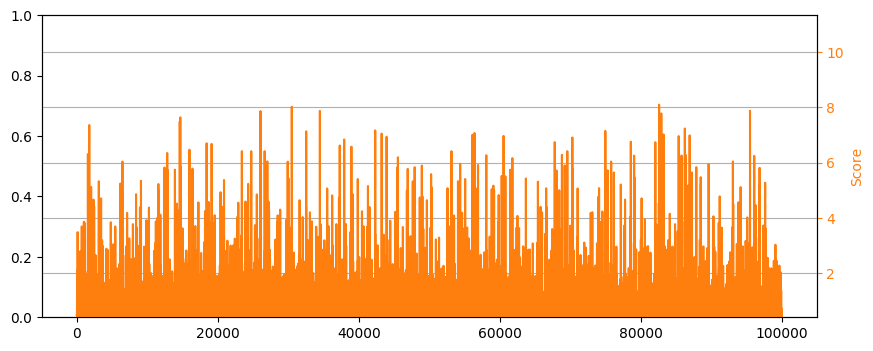

In [71]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
#start, end = 0, len(taxi_data)
#start, end = 5500, 6500
#taxi_data_subset = taxi_data[start:end]

#ax1.plot(subset_df.index, color='C0', alpha=0.8)
ax2.plot(subset_df['score'], color='C1')

ax2.grid(which='major', axis='both')

#ax1.set_ylabel('Index', color='C0')
ax2.set_ylabel('Score', color='C1')

#ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

#ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [78]:
import numpy as np
threshold = 5
#subset_df[ (subset_df.score > threshold)]['calcFraud'] = 1
#subset_df['calcFraud'] = 1 if subset_df['score'] > threshold else 0
subset_df['calcFraud'] = np.where(subset_df['score'] > threshold, 1, 0)

In [79]:
#predicted = []
#acutal = []
#for index, row in subset_df:
 
predicted = subset_df['calcFraud']
test_slice_df = test_df[:num_calculate]
actual = test_slice_df['isFraud']
    

In [117]:
## Ripped from AWS Blog build-multiclass-classifiers-with-amazon-sagemaker-linear-learner

label_map = {0:'Normal', 1:'Fraud'}

def predict(predictor, test_features):
    # tune the predictor to provide the non-verbose response
    predictor.accept = 'application/json'
    
    # split the test dataset into 100 batches and evaluate using prediction endpoint
    print('\nRunning predictions in batches...')
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    print('Predictions done.')

    # parse protobuf responses to extract predicted labels
    test_preds = np.concatenate([np.array([x['predicted_label'] for x in batch['predictions']]) for batch in prediction_batches])
    test_preds = test_preds.reshape((-1,))
    return test_preds
    
def evaluate_metrics(test_preds, test_labels):
    # calculate overall scored
    accuracy = (test_preds == test_labels).sum() / test_labels.shape[0]
    f1_macro = f1_score(test_labels, test_preds, average='macro')
    
    # calculate recall for each class
    recall_per_class, classes = [], []
    for target_label in np.unique(test_labels):
        recall_numerator = np.logical_and(test_preds == target_label, test_labels == target_label).sum()
        recall_denominator = (test_labels == target_label).sum()
        recall_per_class.append(recall_numerator / recall_denominator)
        classes.append(label_map[target_label])
    recall = pd.DataFrame({'recall': recall_per_class, 'class_label': classes})
    recall.sort_values('class_label', ascending=False, inplace=True)

    # calculate confusion matrix
    label_mapper = np.vectorize(lambda x: label_map[x])
    confusion_matrix = pd.crosstab(label_mapper(test_labels), label_mapper(test_preds), 
                                   rownames=['Actuals'], colnames=['Predictions'], normalize='index')

    # display results
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
    ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
    ax.set_ylabel('')
    print('Accuracy: {:.3f}'.format(accuracy))
    print('F1 Score: {:.3f}'.format(f1_macro))

In [ ]:
test_features = test_data.drop(['isFraud'], axis=1).values
test_labels = test_data['isFraud'].values

In [106]:
df_confusion = pd.crosstab(actual, predicted)
print(df_confusion)


calcFraud      0    1
isFraud              
0.0        99787  103
1.0          100   10


Text(0.5,1,'Confusion Matrix')

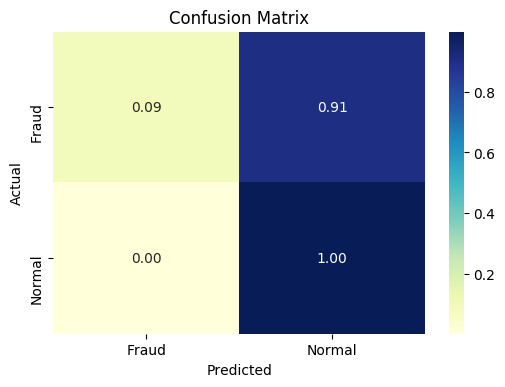

In [119]:

#confusion_matrix(actual, predicted)
label_map = {0:'Normal', 1:'Fraud'}
label_mapper = np.vectorize(lambda x: label_map[x])
confusion_matrix_df = pd.crosstab(label_mapper(actual), label_mapper(predicted), rownames=['Actual'], colnames=['Predicted'], normalize='index')
#confusion_matrix_df = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], normalize='index')

sns.heatmap(confusion_matrix_df, annot=True, fmt='.2f', cmap="YlGnBu").set_title('Confusion Matrix')  
#ax = recall.plot(kind='barh', x='class_label', y='recall', color='steelblue', title='Recall', legend=False)
#ax.set_ylabel('')

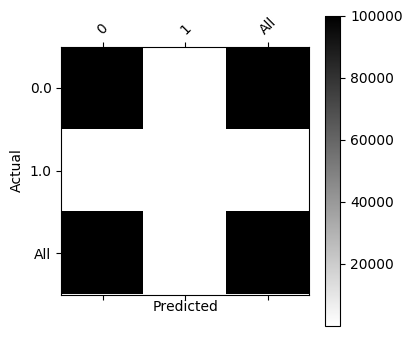

In [93]:
df_confusion = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)

plot_confusion_matrix(df_confusion)

In [115]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2018-12-21-17-29-41-122
